**Predicting Students' Employability**

The data collected using google forms which was circulated amoing students of University of Windsor and was also obtained from Kaggle, will be split up into training and testing sets.

We also analyzed few job descriptions to see what hard skills and soft skills usually a employer looks for while hiring a candidate for certain position.

The questions we seek to answer in the Exploratory Data Analysis portion are:


1. Which characteristic do students score low in? high in?
2. What is the usual cutoff average score for employability according to the dataset?
3. Which feature has the greatest correlation with employability?


In [ ]:
# Configure
print_debug = True
csv_file = '/content/cv.csv' # the csv text data include the following fields: id (int), text (string)

In [ ]:
import pandas as pd #Pandas is a popular data manipulation and analysis library in Python, commonly used for handling tabular data such as CSV files

# Load and clean data
print('Load and clean data')
df = pd.read_csv(csv_file)
df = df.dropna()
df['text'] = df['text'].str.lower()
if print_debug:
    print(df.head(4))

Load and clean data
    id                                               text
0  1.0  "job title: software engineer\ncompany: xyz te...
1  2.0  "job title: data scientist\ncompany: abc data\...
4  3.0  "resume\nname: john doe\ncontact: john.doe@exa...
5  4.0  "resume\nname: jane smith\ncontact: jane.smith...


In [ ]:
# Data preprocessing, but not needed for this project becuase the hugging face pre-trained model already contains a tokenizer.
# If there are more specific requirements on the text extrcation, could build own tokenizer to facilitate the need.
# However, this tokenzier has not considered symbols that are inclued in the skills such as C++ or .NET.

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download([
     "punkt",
     "wordnet",
     "stopwords"
])

tokenised_df = df.copy(deep=True)

# Tokenization
tokenised_df['tokens'] = tokenised_df['text'].apply(word_tokenize)
if print_debug:
     print("Tokenized data")
     print(tokenised_df.head(4))

# Remove stop words, punctuation, and non-alphabetic characters
stop_words = set(stopwords.words('english'))
tokenised_df['tokens'] = tokenised_df['tokens'].apply(lambda x: [word for word in x if word.isalpha() and word not in stop_words])
if print_debug:
     print("Cleaned tokenized data")
     print(tokenised_df.head(4))

# Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
tokenised_df['tokens'] = tokenised_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
if print_debug:
     print("Lemmatized data")
     print(tokenised_df.head(4))

tokenised_df.to_csv('/content/cv_tokenised.csv', index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Tokenized data
    id                                               text  \
0  1.0  "job title: software engineer\ncompany: xyz te...   
1  2.0  "job title: data scientist\ncompany: abc data\...   
4  3.0  "resume\nname: john doe\ncontact: john.doe@exa...   
5  4.0  "resume\nname: jane smith\ncontact: jane.smith...   

                                              tokens  
0  [``, job, title, :, software, engineer\ncompan...  
1  [``, job, title, :, data, scientist\ncompany, ...  
4  [``, resume\nname, :, john, doe\ncontact, :, j...  
5  [``, resume\nname, :, jane, smith\ncontact, :,...  
Cleaned tokenized data
    id                                               text  \
0  1.0  "job title: software engineer\ncompany: xyz te...   
1  2.0  "job title: data scientist\ncompany: abc data\...   
4  3.0  "resume\nname: john doe\ncontact: john.doe@exa...   
5  4.0  "resume\nname: jane smith\ncontact: jane.smith...   

                                              tokens  
0  [job, title, soft

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Lemmatized data
    id                                               text  \
0  1.0  "job title: software engineer\ncompany: xyz te...   
1  2.0  "job title: data scientist\ncompany: abc data\...   
4  3.0  "resume\nname: john doe\ncontact: john.doe@exa...   
5  4.0  "resume\nname: jane smith\ncontact: jane.smith...   

                                              tokens  
0  [job, title, software, xyz, san, francisco, de...  
1  [job, title, data, abc, new, york, description...  
4  [john, utilize, skill, experience, software, e...  
5  [jane, seeking, challenging, role, data, scien...  


**This script is designed to extract soft and hard skills from text data (e.g., CVs or resumes) using pre-trained models from the HuggingFace Model Hub and is compatible with Jupyter Notebook and Python 3.10.1. The script uses two transformer-based models to perform this task:**

**Soft skills extraction**
**Hard/Knowledge skills extraction**

**The extracted skills are stored in a pandas DataFrame and saved as a CSV file.**

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
# Load pre-trained models
# soft skills extraction: https://huggingface.co/jjzha/jobbert_skill_extraction
# hard skills extraction: https://huggingface.co/jjzha/jobbert_knowledge_extraction
token_soft_skill_classifier = pipeline(model='jjzha/jobbert_skill_extraction', aggregation_strategy='first')
token_hard_skill_classifier = pipeline(model='jjzha/jobbert_knowledge_extraction', aggregation_strategy='first')

def aggregate_skill_span(results):
    """Aggregate consecutive classified ntities into one.
    """
    new_results = []
    current_result = results[0]

    for result in results[1:]:
        if result["start"] <= current_result["end"] + 1:
            current_result["word"] += " " + result["word"]
            current_result["end"] = result["end"]
        else:
            new_results.append(current_result)
            current_result = result

    new_results.append(current_result)

    # remove invalid skills that are 1 character and none-alphabet (e.g. punctuation or other symbols that are wrongly classifierd)
    new_results = [x for x in new_results if (len(x["word"]) > 1 or x["word"].isalpha())]

    # remove invalid skills that are all numeric
    new_results = [x for x in new_results if (not x["word"].isnumeric())]

    return [x for x in new_results if (len(x["word"]) > 1 or x["word"].isalpha())]

def extract_skill_entities(text):
    """Extract both soft and hard skills
    """
    # soft skills
    output_soft_skills = token_soft_skill_classifier(text)
    for result in output_soft_skills:
        if result.get("entity_group"):
            result["entity"] = "Soft Skill"
            del result["entity_group"]
    # hard skills
    output_hard_skills = token_hard_skill_classifier(text)
    for result in output_hard_skills:
        if result.get("entity_group"):
            result["entity"] = "Hard Skill"
            del result["entity_group"]
    # aggregates
    if len(output_soft_skills) > 0:
        output_soft_skills = aggregate_skill_span(output_soft_skills)
    if len(output_hard_skills) > 0:
        output_hard_skills = aggregate_skill_span(output_hard_skills)


    return output_soft_skills, output_hard_skills

# Copy dataframe and create placeholder for soft and hard skills
out_df = df.copy(deep=True)
out_df['soft_skills'] = pd.Series(dtype='string')
out_df['hard_skills'] = pd.Series(dtype='string')

# Loop through each row
score_thres = 0.5
for i, row in out_df.iterrows():
    output_soft_skills, output_hard_skills = extract_skill_entities(row['text'])

    # Extract soft skills
    soft_skills = set()
    for soft_skill in output_soft_skills:
        if soft_skill['score'] > score_thres:
            soft_skills.add(soft_skill['word'])
    if soft_skills:
        out_df.at[i,'soft_skills'] = str(soft_skills)

    # Extract hard skills
    hard_skills = set()
    for hard_skill in output_hard_skills:
        if hard_skill['score'] > score_thres:
            hard_skills.add(hard_skill['word'])
    if hard_skills:
        out_df.at[i,'hard_skills'] = str(hard_skills)

    if print_debug:
        print(f'CV ID: {i}')
        print('\tSoft Skills')
        print(soft_skills)
        print('\tHard Skills')
        print(hard_skills)

out_df.to_csv('/content/cv_classified.csv', index=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CV ID: 0
	Soft Skills
{'gathering user requirements', 'writing code', 'organizational and leadership skills', 'design and develop software solutions', 'analytical mind', 'passionate', 'defining system functionality', 'problem - solving aptitude', 'work independently'}
	Hard Skills
{'scripting', 'java', 'software development', 'nosql databases', 'java / j2ee platform', 'selected programming languages', 'ruby on rails', 'system monitoring tools', 'relational databases', 'automated testing frameworks', 'mysql', 'jscript. net', 'software', 'c + +', 'project management', 'new relic', '. net programming languages'}
CV ID: 1
	Soft Skills
{', activities and design', 'develop analysis and reporting capabilities', 'identify improvements', 'business acumen', 'communication and presentation skills', 'math skills', 'analytical mind', 'problem - solving aptitude', 'analyze large amounts of raw information', 'conducting full lifecycle analysis', 'monitor performance and quality control plans', 'find 

**SOFT SKILLS PLOT AGAINST EMPLOYABILITY RATE**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Import Dataset

Change binary classifcation in CLASS to 1 for Employable and 0 for LessEmployable

Each import will be showing its first 5 rows of data as a preview.

In [ ]:
student_data = pd.read_excel("/content/Student-Employability-Datasets.xlsx")
df = student_data
cols =list(df.columns)
df["CLASS"] = (df["CLASS"] == "Employable").astype(int)
df.head()

,Name of Student,GENERAL APPEARANCE,MANNER OF SPEAKING,PHYSICAL CONDITION,MENTAL ALERTNESS,SELF-CONFIDENCE,ABILITY TO PRESENT IDEAS,COMMUNICATION SKILLS,Student Performance Rating,CLASS
0,Student 1,4,5,4,5,5,5,5,5,1
1,Student 2,4,4,4,4,4,4,3,5,1
2,Student 3,4,3,3,3,3,3,2,5,0
3,Student 4,3,3,3,2,3,3,3,5,0
4,Student 5,4,4,3,3,4,4,3,5,1


#Data Preprocessing
Check if there are any missing values in the datasets.

In [ ]:
# Checking if there are any NaN values in the student dataset

student_data_nan_count = student_data.isna().sum().sum()
student_data_nan_count

0

Both datasets do not have NaN values. Scaling is not necessary since all data have been measured on the same range. Normalization is recommended but not required since the project will not make use of Gaussian models.

# Plots and Analysis
1. Which characteristic do students score low in? high in?

In [ ]:
# Calculate average for each characteristic

col_means = student_data.loc[:, "GENERAL APPEARANCE":"Student Performance Rating"].mean().to_frame().set_axis(["Mean"], axis=1)
col_means = col_means.sort_values(by="Mean", ascending=False)
col_means

,Mean
Student Performance Rating,4.610664
GENERAL APPEARANCE,4.246814
PHYSICAL CONDITION,3.972166
MENTAL ALERTNESS,3.962777
SELF-CONFIDENCE,3.910798
MANNER OF SPEAKING,3.884641
ABILITY TO PRESENT IDEAS,3.813883
COMMUNICATION SKILLS,3.525486


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Student Performance Rating'),
  Text(1, 0, 'GENERAL APPEARANCE'),
  Text(2, 0, 'PHYSICAL CONDITION'),
  Text(3, 0, 'MENTAL ALERTNESS'),
  Text(4, 0, 'SELF-CONFIDENCE'),
  Text(5, 0, 'MANNER OF SPEAKING'),
  Text(6, 0, 'ABILITY TO PRESENT IDEAS'),
  Text(7, 0, 'COMMUNICATION SKILLS')])

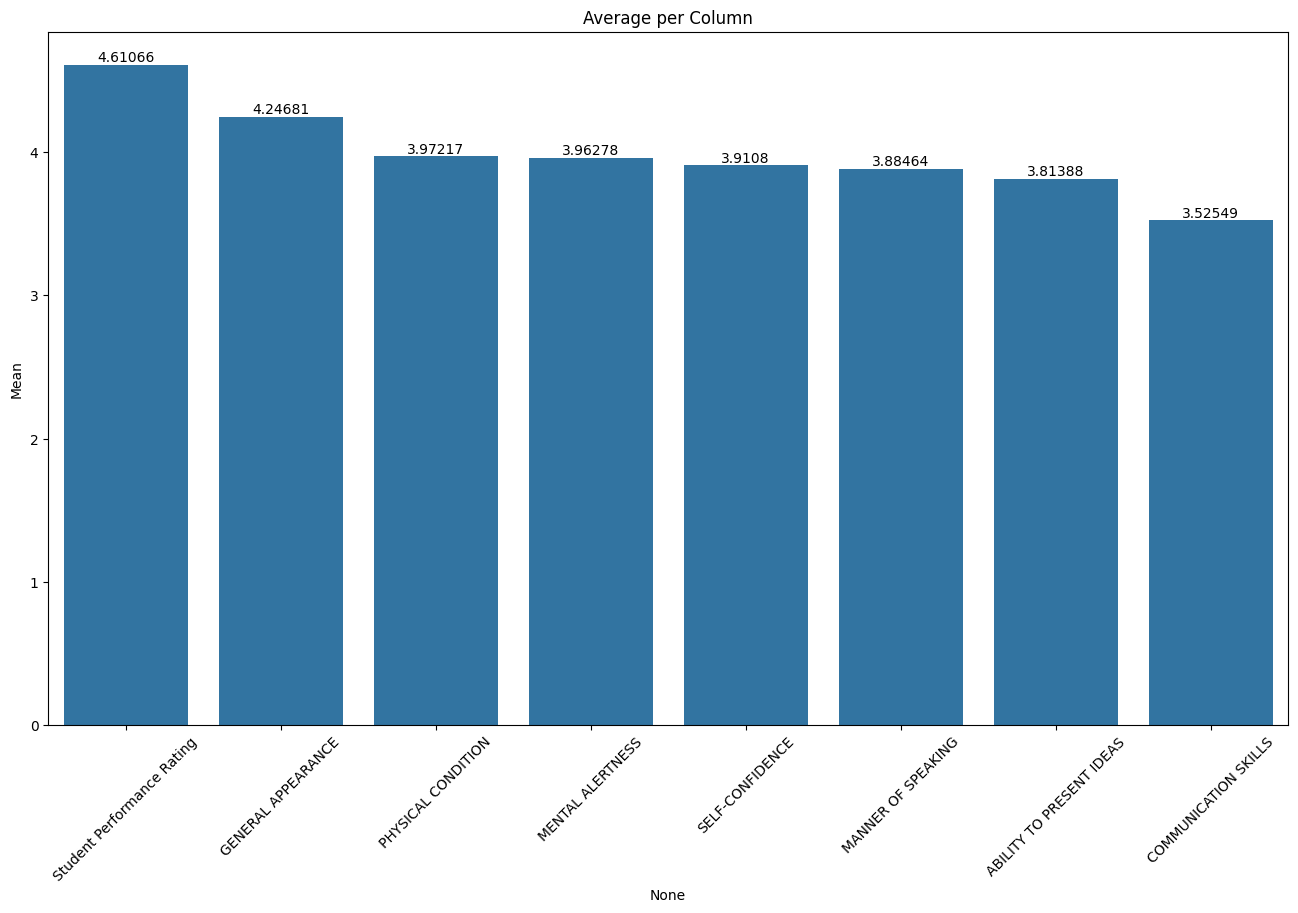

In [ ]:
# Generate plot for average per column

plt.figure(figsize=(16,9))
plt.title("Average per Column")
ax = sns.barplot(data=col_means, x=col_means.index, y="Mean")
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)

Students currently have a high average performance rating of 4.61066.
In terms of lowest rating, they averaged the lowest in communication skills at around 3.52549.
This is related to their relatively close scores of presenting ideas and manners of speaking.


#2. What is the usual cutoff average score for employability according to the dataset?

In [ ]:
temp_student_data = student_data.copy()
temp_student_data["Average Score"] = temp_student_data.mean(axis=1)
temp_student_data.sort_values(by="Average Score")

<ipython-input-10-c9948655265a>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  temp_student_data["Average Score"] = temp_student_data.mean(axis=1)


,Name of Student,GENERAL APPEARANCE,MANNER OF SPEAKING,PHYSICAL CONDITION,MENTAL ALERTNESS,SELF-CONFIDENCE,ABILITY TO PRESENT IDEAS,COMMUNICATION SKILLS,Student Performance Rating,CLASS,Average Score
741,Student 742,3,3,3,3,3,2,2,4,0,2.555556
2725,Student 2744,3,3,3,3,3,2,2,4,0,2.555556
1105,Student 1106,3,3,3,3,3,2,2,4,0,2.555556
195,Student 196,3,3,3,3,3,2,2,4,0,2.555556
923,Student 924,3,3,3,3,3,2,2,4,0,2.555556
...,...,...,...,...,...,...,...,...,...,...,...
297,Student 298,5,5,5,5,5,5,5,5,1,4.555556
1207,Student 1208,5,5,5,5,5,5,5,5,1,4.555556
661,Student 662,5,5,5,5,5,5,5,5,1,4.555556
1025,Student 1026,5,5,5,5,5,5,5,5,1,4.555556


This question cannot be answered since as proven by the table returned, having a high or low average score does not guarantee employability. This can be further discussed in the next question on which characteristic has the greatest correlation with employability.

# 3. Which feature has the greatest correlation with employability?

<ipython-input-11-f3831e36167f>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(student_data.corr(), vmin=-1, vmax=1, annot=True)


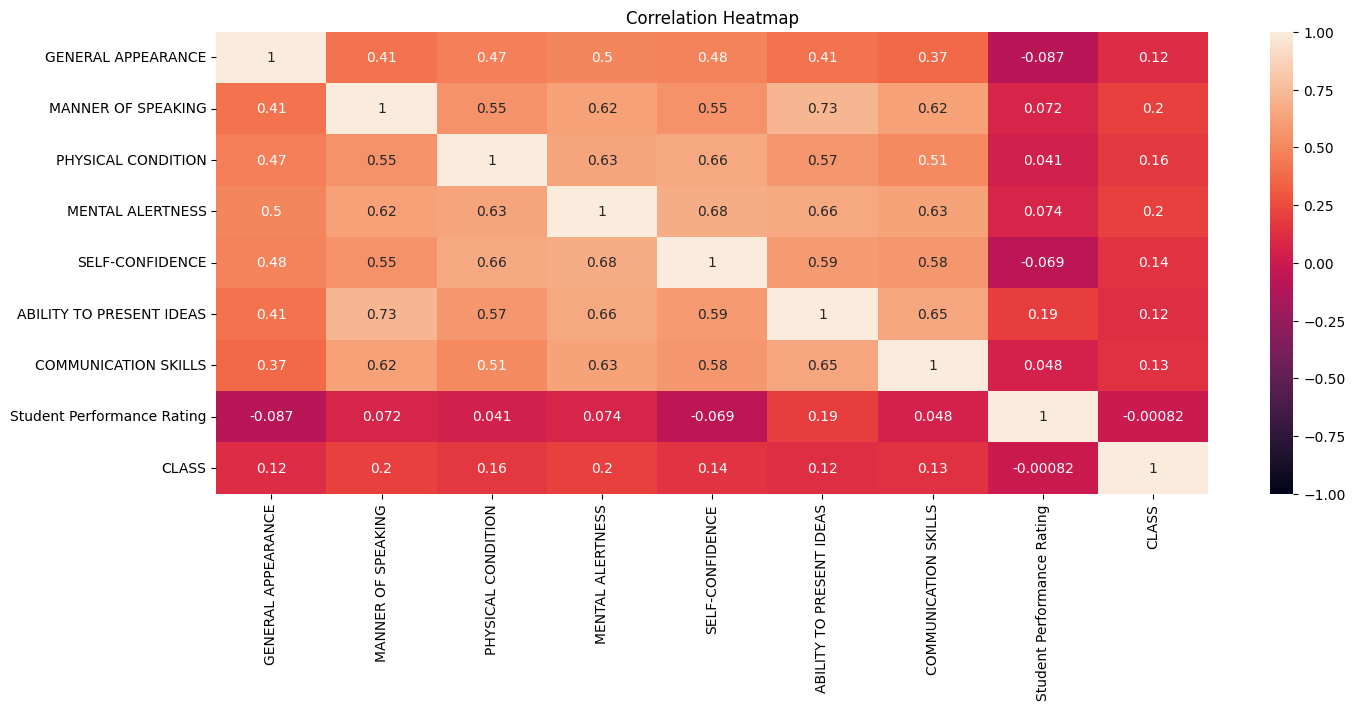

In [ ]:
# Generate heatmap for correlation towards employability

plt.figure(figsize=(16, 6))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(student_data.corr(), vmin=-1, vmax=1, annot=True)

Based on the correlation heatmap, there is no strong positive or negative correlations between any of the features with employability. The ones with the highest absolute correlation are Manner of Speaking and Mental Alertness. However, their correlation coefficients are closer to zero which means there is strong linear trend between the features with employability.

#Splitting Training and Validation Data

In [ ]:
# Select features from the dataset

X = student_data.loc[:, "GENERAL APPEARANCE":"Student Performance Rating"]
X

,GENERAL APPEARANCE,MANNER OF SPEAKING,PHYSICAL CONDITION,MENTAL ALERTNESS,SELF-CONFIDENCE,ABILITY TO PRESENT IDEAS,COMMUNICATION SKILLS,Student Performance Rating
0,4,5,4,5,5,5,5,5
1,4,4,4,4,4,4,3,5
2,4,3,3,3,3,3,2,5
3,3,3,3,2,3,3,3,5
4,4,4,3,3,4,4,3,5
...,...,...,...,...,...,...,...,...
2977,4,3,3,3,3,3,2,5
2978,3,4,4,4,4,4,4,5
2979,4,5,4,5,4,4,4,5
2980,4,4,4,3,4,4,3,5


In [ ]:
# Prediction target is CLASS or employability

y = student_data["CLASS"]

In [ ]:
# Split data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [ ]:
# Create a dataframe for comparison of testing set and predictions

df_pred = pd.concat([X_test, y_test], axis=1)
df_pred

,GENERAL APPEARANCE,MANNER OF SPEAKING,PHYSICAL CONDITION,MENTAL ALERTNESS,SELF-CONFIDENCE,ABILITY TO PRESENT IDEAS,COMMUNICATION SKILLS,Student Performance Rating,CLASS
316,3,3,4,4,4,3,3,4,0
2349,4,4,4,4,4,4,3,5,1
2549,4,3,3,4,5,4,3,5,0
891,4,3,4,2,2,2,2,5,0
1284,5,5,5,5,5,5,4,5,0
...,...,...,...,...,...,...,...,...,...
1477,5,4,4,4,4,4,4,3,1
933,4,3,3,3,5,3,3,3,0
438,3,4,4,4,3,4,3,5,1
2517,4,4,4,4,4,4,4,4,1


#Training and Testing Models
1. Logistic Regression

In [ ]:
# Training logistic regression model

logreg_model = LogisticRegression(solver='lbfgs')
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Generating dataframe for predictions

logreg_preds = logreg_model.predict(X_test)
logreg_df = df_pred.copy()
logreg_df["Prediction"] = logreg_preds
logreg_df

,GENERAL APPEARANCE,MANNER OF SPEAKING,PHYSICAL CONDITION,MENTAL ALERTNESS,SELF-CONFIDENCE,ABILITY TO PRESENT IDEAS,COMMUNICATION SKILLS,Student Performance Rating,CLASS,Prediction
316,3,3,4,4,4,3,3,4,0,1
2349,4,4,4,4,4,4,3,5,1,1
2549,4,3,3,4,5,4,3,5,0,0
891,4,3,4,2,2,2,2,5,0,0
1284,5,5,5,5,5,5,4,5,0,1
...,...,...,...,...,...,...,...,...,...,...
1477,5,4,4,4,4,4,4,3,1,1
933,4,3,3,3,5,3,3,3,0,0
438,3,4,4,4,3,4,3,5,1,1
2517,4,4,4,4,4,4,4,4,1,1


In [ ]:
# Printing the rows that got the prediction wrong

wrong_logreg_preds = logreg_df[logreg_df["Prediction"] != logreg_df["CLASS"]]
wrong_logreg_preds

,GENERAL APPEARANCE,MANNER OF SPEAKING,PHYSICAL CONDITION,MENTAL ALERTNESS,SELF-CONFIDENCE,ABILITY TO PRESENT IDEAS,COMMUNICATION SKILLS,Student Performance Rating,CLASS,Prediction
316,3,3,4,4,4,3,3,4,0,1
1284,5,5,5,5,5,5,4,5,0,1
2419,4,4,4,4,4,4,4,5,0,1
2956,4,4,4,3,4,3,3,4,0,1
2374,4,4,4,4,3,3,3,3,0,1
...,...,...,...,...,...,...,...,...,...,...
1611,5,4,3,3,3,3,2,3,0,1
2063,4,4,4,4,4,4,4,5,0,1
1583,5,3,5,4,5,5,3,5,1,0
1511,4,4,4,4,3,4,4,5,0,1


In [ ]:
# Calculating the score of the model

logreg_score = accuracy_score(y_test, logreg_preds)
logreg_score*100

60.05361930294906

# The logistic regression model managed to get around 60% of the employability classification correctly.

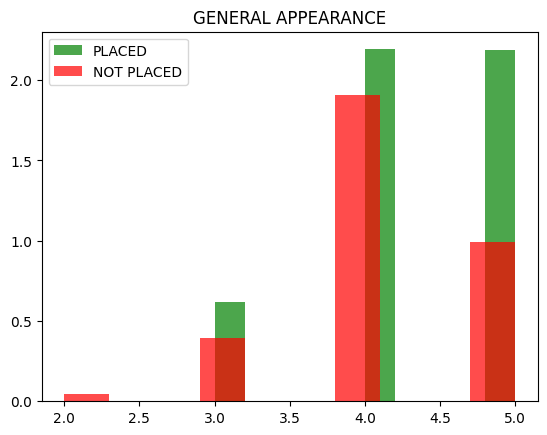

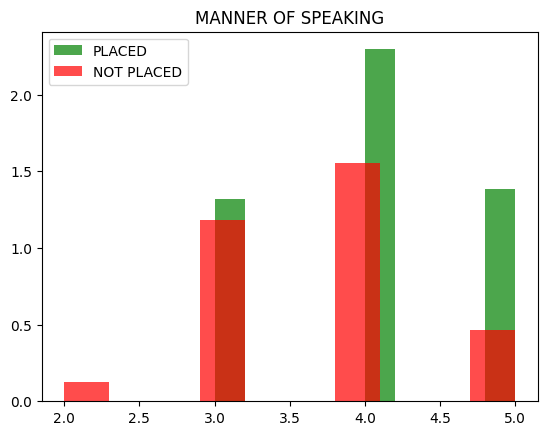

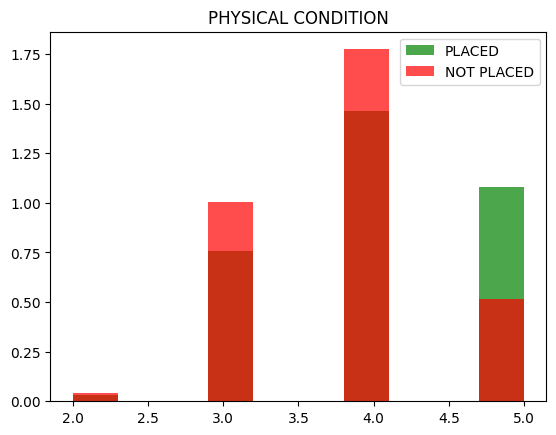

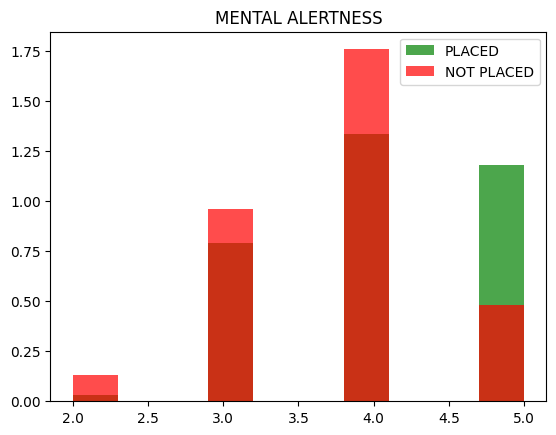

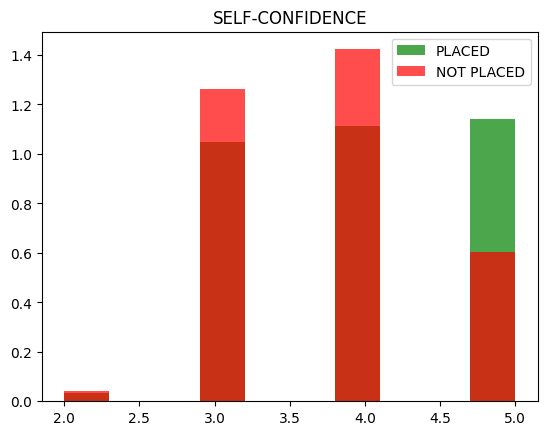

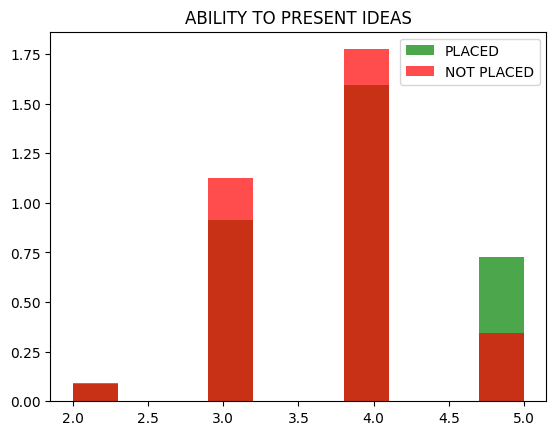

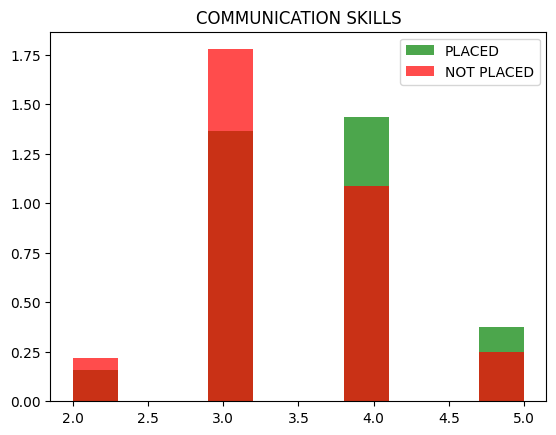

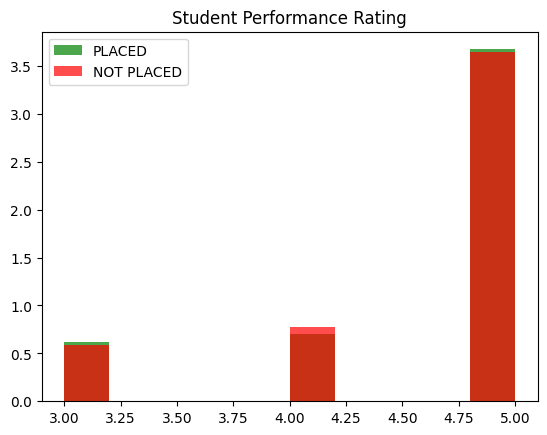

In [ ]:
for label in cols[1:-1]:
    plt.hist(df[df["CLASS"]==1][label] , color="green",label="PLACED",alpha = 0.7 , density=True)
    plt.hist(df[df["CLASS"]==0][label] , color="red",label="NOT PLACED",alpha = 0.7 , density=True)
    plt.legend()
    plt.title(label)
    plt.show()